# 🧠 XAI with Vision Transformer (ViT-Tiny) on CIFAR-10
This notebook demonstrates **Grad-CAM** and **Integrated Gradients** on a small ViT trained on CIFAR-10.
We use `timm` for the ViT model, `captum` for IG, and standard `torchvision` for dataset handling.

In [2]:
# Install dependencies (uncomment if needed)
!pip install torch torchvision timm captum matplotlib numpy opencv-python pillow

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
import timm
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients
import cv2
from PIL import Image

## 1️⃣ Prepare CIFAR-10 dataset

In [3]:
img_size = 224
batch_size = 64

transform = T.Compose([
    T.Resize((img_size,img_size)),
    T.ToTensor(),
    T.Normalize((0.4914,0.4822,0.4465),(0.247,0.243,0.261))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## 2️⃣ Create ViT-Tiny model

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = timm.create_model('vit_tiny_patch16_224', pretrained=True)
model.head = nn.Linear(model.head.in_features, 10)  # CIFAR-10 has 10 classes
model.to(device)
model.eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)


## 3️⃣ Training (optional, can skip if using pretrained features)

In [ ]:
# Simple one-epoch training demo (for showcase)
# Comment out if you only want inference

# optimizer = optim.Adam(model.parameters(), lr=3e-4)
# loss_fn = nn.CrossEntropyLoss()

# for epoch in range(1):
#     model.train()
#     running_loss = 0
#     for x, y in train_loader:
#         x, y = x.to(device), y.to(device)
#         optimizer.zero_grad()
#         logits = model(x)
#         loss = loss_fn(logits, y)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()*x.size(0)
#     print('Train loss:', running_loss/len(train_loader.dataset))

## 4️⃣ Define Grad-CAM for ViT

In [5]:
class ViTGradCAM:
    def __init__(self, model):
        self.model = model.eval()
        self.gradients = None
        self.activations = None

        last_block = model.blocks[-1]
        self.hooks = []

        def forward_hook(module, inp, out):
            self.activations = out.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.hooks.append(last_block.register_forward_hook(forward_hook))
        self.hooks.append(last_block.register_backward_hook(backward_hook))

    def generate_cam(self, pil_img, preprocess, target_class=None):
        device = next(self.model.parameters()).device
        x = preprocess(pil_img).unsqueeze(0).to(device)
        logits = self.model(x)
        if target_class is None:
            target_class = logits.argmax(dim=1).item()

        self.model.zero_grad()
        loss = logits[0, target_class]
        loss.backward(retain_graph=True)

        grads = self.gradients
        acts = self.activations
        weights = grads.mean(dim=-1)
        weights_np = weights[0].cpu().numpy()[1:]
        n_patches = acts.shape[1] - 1
        grid_size = int(np.sqrt(n_patches))
        cam = weights_np.reshape(grid_size, grid_size)
        cam_resized = cv2.resize(cam, pil_img.size)
        cam_norm = (cam_resized - cam_resized.min()) / (cam_resized.max()-cam_resized.min()+1e-8)
        return cam_norm

def show_overlay(img, heatmap, alpha=0.5, title='Grad-CAM'):
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.imshow(heatmap, cmap='jet', alpha=alpha)
    plt.axis('off')
    plt.title(title)
    plt.show()

## 5️⃣ Define Integrated Gradients for ViT

In [6]:
class ViTIntegratedGradients:
    def __init__(self, model, preprocess):
        self.model = model.eval()
        self.preprocess = preprocess
        self.ig = IntegratedGradients(self.model)
        self.device = next(model.parameters()).device

    def attribute(self, pil_img, target_class=None, baseline=None, n_steps=50):
        x = self.preprocess(pil_img).unsqueeze(0).to(self.device)
        if baseline is None:
            baseline = torch.zeros_like(x).to(self.device)
        attr = self.ig.attribute(x, baselines=baseline, target=target_class, n_steps=n_steps)
        saliency = attr.squeeze(0).sum(0).cpu().detach().numpy()
        saliency = (saliency - saliency.min()) / (saliency.max()-saliency.min()+1e-8)
        return saliency

## 6️⃣ Pick a sample image

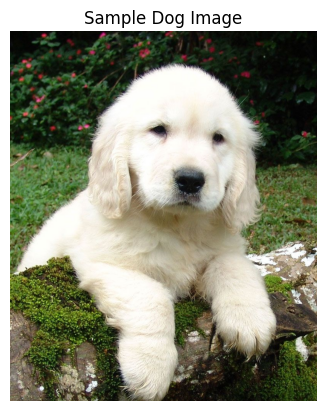

In [7]:
from PIL import Image
from io import BytesIO
import requests
import matplotlib.pyplot as plt

url = "https://upload.wikimedia.org/wikipedia/commons/6/6e/Golde33443.jpg"  # Golden retriever
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}

response = requests.get(url, headers=headers)
img = Image.open(BytesIO(response.content)).convert("RGB")

plt.imshow(img)
plt.axis("off")
plt.title("Sample Dog Image")
plt.show()

## 7️⃣ Preprocess function

In [10]:
preprocess = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize((0.4914,0.4822,0.4465),(0.247,0.243,0.261))
])

## 8️⃣ Run Grad-CAM

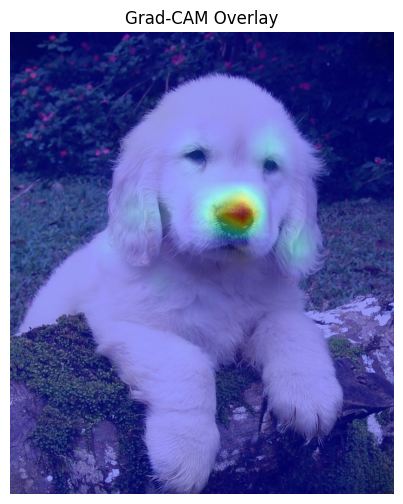

In [8]:

input_tensor = transform(img).unsqueeze(0)


activations = None
gradients = None

def save_activation(module, input, output):
    global activations
    activations = output  # (B, num_patches+1, hidden)

def save_gradient(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0]

target_layer = model.blocks[-1].norm1
target_layer.register_forward_hook(save_activation)
target_layer.register_full_backward_hook(save_gradient)

# --------------------
# 4. Forward + backward
# --------------------
output = model(input_tensor)
pred_class = output.argmax(dim=1)
output[0, pred_class].backward()

# --------------------
# 5. Compute Grad-CAM
# --------------------
# gradients: (B, N+1, H), activations: (B, N+1, H)
weights = gradients.mean(dim=-1)  # (B, N+1)
weights = weights[0, 1:]         # skip CLS token

activ = activations[0, 1:, :]    # skip CLS token
cam = (weights.unsqueeze(-1) * activ).sum(-1).detach().cpu().numpy()

# reshape to patch grid
num_patches = cam.shape[0]
grid_size = int(np.sqrt(num_patches))
cam = cam.reshape(grid_size, grid_size)

# upsample to image size
cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
cam = np.uint8(cam * 255)
cam = Image.fromarray(cam).resize(img.size, resample=Image.BILINEAR)
cam = np.array(cam) / 255.0

# --------------------
# 6. Overlay
# --------------------
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.imshow(cam, cmap='jet', alpha=0.4)
plt.axis('off')
plt.title("Grad-CAM Overlay")
plt.show()


## 9️⃣ Run Integrated Gradients

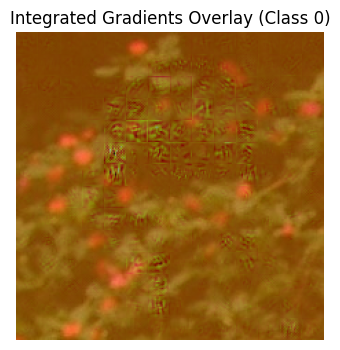

In [11]:
# Get the predicted class first
with torch.no_grad():
    x = preprocess(img).unsqueeze(0).to(next(model.parameters()).device)
    logits = model(x)
    if isinstance(logits, dict):  # handle models that return dict
        logits = logits['logits']
    pred_class = logits.argmax(dim=1).item()

# Now run Integrated Gradients
expl_ig = ViTIntegratedGradients(model, preprocess)
saliency = expl_ig.attribute(img, target_class=pred_class)  # <- FIXED here

# Show overlay
plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.imshow(saliency, cmap='hot', alpha=0.5)
plt.axis('off')
plt.title(f'Integrated Gradients Overlay (Class {pred_class})')
plt.show()
